In [ ]:
pip install rhino3dm

In [ ]:
pip install openseespy

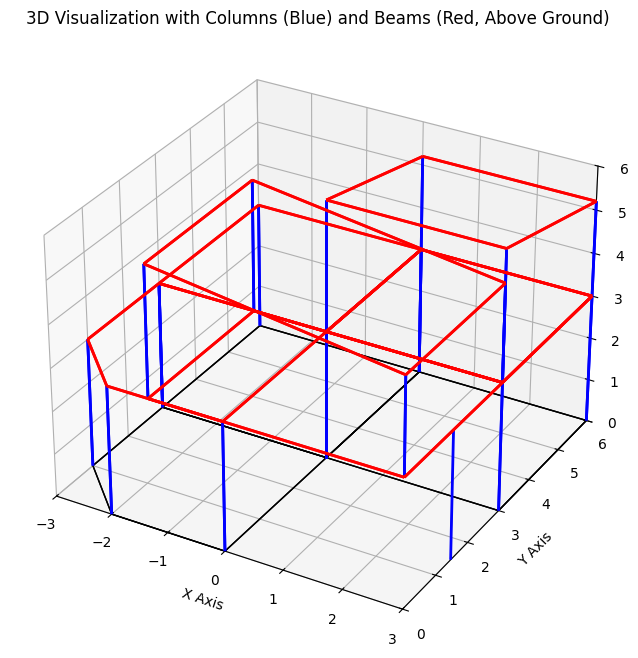

In [ ]:
import rhino3dm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def get_all_edges(geometry):
    """
    Extracts edges from Breps and Meshes, returning pairs of connected vertices.
    """
    edges = []

    for geom in geometry:
        # Extract edges from Brep
        if isinstance(geom, rhino3dm.Brep):
            for edge in geom.Edges:
                start = [edge.PointAtStart.X, edge.PointAtStart.Y, edge.PointAtStart.Z]
                end = [edge.PointAtEnd.X, edge.PointAtEnd.Y, edge.PointAtEnd.Z]
                edges.append([start, end])

        # If it's a Mesh, extract edges by connecting vertices
        elif isinstance(geom, rhino3dm.Mesh):
            for i in range(geom.TopologyEdges.Count):
                line = geom.TopologyEdges.EdgeLine(i)
                start = [line.From.X, line.From.Y, line.From.Z]
                end = [line.To.X, line.To.Y, line.To.Z]
                edges.append([start, end])

    return np.array(edges)

def add_structural_elements(edges):
    """
    Adds columns at vertical edges and beams along all non-ground horizontal & tilted edges.
    """
    columns = []
    beams = []

    # Find the lowest Z value (ground level)
    z_values = [point[2] for edge in edges for point in edge]
    ground_level = min(z_values) + 0.2  # Small buffer to avoid near-ground beams

    for edge in edges:
        start, end = edge
        vector = np.array(end) - np.array(start)

        # Identify columns (strictly vertical edges)
        if abs(vector[0]) < 0.1 and abs(vector[1]) < 0.1:  # Vertical alignment check
            columns.append(edge)

        # Identify beams (non-vertical edges, excluding those near ground level)
        elif abs(vector[2]) < 1.5 and start[2] > ground_level and end[2] > ground_level:
            beams.append(edge)

    return np.array(columns), np.array(beams)

# Load the Rhino 3DM file
file_path = "/content/basicformMETERS.3dm"  # Update with your file path

try:
    model = rhino3dm.File3dm.Read(file_path)
    geometry = [obj.Geometry for obj in model.Objects if obj.Geometry is not None]

    # Extract edges
    edges = get_all_edges(geometry)

    # Identify columns and beams
    columns, beams = add_structural_elements(edges)

    # Plot edges, columns, and beams in 3D
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Convert edges to a format suitable for Line3DCollection
    edge_lines = [np.array(edge) for edge in edges]
    column_lines = [np.array(col) for col in columns]
    beam_lines = [np.array(beam) for beam in beams]

    # Add the original edges in black
    ax.add_collection3d(Line3DCollection(edge_lines, colors='black', linewidths=1))

    # Add columns in blue
    ax.add_collection3d(Line3DCollection(column_lines, colors='blue', linewidths=2))

    # Add beams in red (Now avoids beams near ground level)
    ax.add_collection3d(Line3DCollection(beam_lines, colors='red', linewidths=2))

    # Set axis labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('3D Visualization with Columns (Blue) and Beams (Red, Above Ground)')

    # Auto scale axes
    all_points = edges.reshape(-1, 3)
    ax.set_xlim([np.min(all_points[:, 0]), np.max(all_points[:, 0])])
    ax.set_ylim([np.min(all_points[:, 1]), np.max(all_points[:, 1])])
    ax.set_zlim([np.min(all_points[:, 2]), np.max(all_points[:, 2])])

    plt.show()

except Exception as e:
    print("Error loading or processing the file:", e)


In [ ]:
import numpy as np
import pandas as pd
import openseespy.opensees as ops

# For optional 3D plotting (if desired)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# 2.1 Read columns, beams, and all_edges DataFrames
columns_df = pd.read_csv(r"/content/columns.csv")   # e.g. x_start, y_start, z_start, x_end, y_end, z_end
beams_df   = pd.read_csv(r"/content/beams.csv")     # same or similar format
edges_df   = pd.read_csv(r"/content/all_edges.csv") # possibly the union or adjacency data

# 2.2 Tag each entry to differentiate them if needed
columns_df["type"] = "column"
beams_df["type"]   = "beam"
edges_df["type"]   = "edge"  # if it’s purely adjacency or combined edges


In [ ]:
combined_df = pd.concat([columns_df, beams_df, edges_df], ignore_index=True)

In [ ]:
node_map = {}  # (x, y, z) -> node_id
next_node_id = 1

for _, row in combined_df.iterrows():
    coord_start = (row["start_x"], row["start_y"], row["start_z"])
    coord_end   = (row["end_x"], row["end_y"], row["end_z"])

    if coord_start not in node_map:
        node_map[coord_start] = next_node_id
        next_node_id += 1
    if coord_end not in node_map:
        node_map[coord_end] = next_node_id
        next_node_id += 1

# Store the node IDs in the DataFrame for convenience
combined_df["startNode"] = combined_df.apply(
    lambda r: node_map[(r["start_x"], r["start_y"], r["start_z"])],
    axis=1
)
combined_df["endNode"] = combined_df.apply(
    lambda r: node_map[(r["end_x"], r["end_y"], r["end_z"])],
    axis=1
)


In [ ]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)  # 3D model, 6 DOFs per node

In [ ]:
node_map = {}  # (x, y, z) -> node_id
next_node_id = 1

In [ ]:
for coord, node_id in node_map.items():
    (x, y, z) = coord
    ops.node(node_id, x, y, z)

# Example boundary condition: fix all nodes where z ~ 0
for coord, node_id in node_map.items():
    x, y, z = coord
    if abs(z) < 1e-8:
        ops.fix(node_id, 1,1,1,1,1,1)  # fully fixed


In [ ]:
E  = 2.1e11     # Young's modulus (Pa)
G  = 8.0769e10  # Shear modulus
A  = 0.02       # Cross-sectional area (m^2)
Iz = 8.3e-5     # Moment of inertia about z
Iy = 4.2e-5     # Moment of inertia about y
J  = 1.0e-4     # Torsional inertia

# Example transformation (3D)
transfTag = ops.geomTransf("Linear", 1, 0, 0, 0, 1, 0)  # local y or z axis vector, etc.


In [ ]:
# Create a copy so we don't alter combined_df in-place
df_copy = combined_df.copy()

# Force each row to store (min_node, max_node) to unify duplicates
df_copy[["startNode", "endNode"]] = df_copy.apply(
    lambda r: pd.Series(sorted((r["startNode"], r["endNode"]))),
    axis=1
)

# Now drop duplicates on the sorted pairs
unique_df = df_copy.drop_duplicates(subset=["startNode", "endNode"])


In [ ]:
elemTag = 1
for idx, row in combined_df.iterrows():
    start_id = int(row["startNode"])
    end_id   = int(row["endNode"])

    # Decide section properties based on type
    if row["type"] == "column":
        # For instance, a column might have a different cross-section
        # Use start_id and end_id for element definition
        ops.element('elasticBeamColumn', elemTag, start_id, end_id, A, E, G, J, Iy, Iz, 1)
    elif row["type"] == "beam":
        # Another approach for beams
        # Use start_id and end_id for element definition
        ops.element('elasticBeamColumn', elemTag, start_id, end_id, A, E, G, J, Iy, Iz, 1)
    else:
        # If "edge" is something generic (like a bracing?), treat it similarly
        # Use start_id and end_id for element definition
        ops.element('elasticBeamColumn', elemTag, start_id, end_id, A, E, G, J, Iy, Iz, 1)

    elemTag += 1

WARNING Domain::addElement - In element 1
 no Node 1 exists in the domain
ERROR could not add element to domain.


OpenSeesError: See stderr output

In [ ]:
# 5.1 Time series & load pattern
ops.timeSeries("Constant", 1)
ops.pattern("Plain", 1, 1)

gravity = -9.81  # negative z direction, if Z is vertical
mass_per_node = 1000.0  # example (kg) or (mass units), adjust to your model scale

for coord, node_id in node_map.items():
    # Assign mass in all translational DOFs
    # mass = [mX, mY, mZ, rX, rY, rZ] for a 3D problem if needed
    # We'll just do translational:
    ops.mass(node_id, mass_per_node, mass_per_node, mass_per_node, 0.0, 0.0, 0.0)

# Apply gravity as acceleration load
ops.loadConst('-time', 0.0)  # This finalizes the mass assignment


NameError: name 'ops' is not defined

In [ ]:
ops.system("BandGeneral")
ops.numberer("RCM")
ops.constraints("Plain")
ops.test("NormUnbalance", 1e-6, 10)
ops.algorithm("Newton")
ops.integrator("LoadControl", 1.0)
ops.analysis("Static")

# In OpenSees, you can set the gravity factor:
ops.record()  # optional, if you want to record data
ops.setTime(0.0)
ops.analyze(1)  # single step


WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 0


0

In [ ]:
# Print reactions for nodes at base (z=0).
for coord, node_id in node_map.items():
    if abs(coord[2]) < 1e-8:
        rxn = ops.nodeReaction(node_id)
        print(f"Node {node_id} at {coord}, Reaction = {rxn}")


Node 1 at (0.0, 3.0, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 3 at (-3.0, 3.0, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 5 at (0.0, 6.0, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 7 at (-3.0, 6.0, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 9 at (3.0, 3.0, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 11 at (3.0, 6.0, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 14 at (2.999987640351348, 1.4681466126439418, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 22 at (0.0, 0.0, 0.0), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 24 at (-2.000000000000001, -3.552713678800501e-15, 1.4210854715202005e-15), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Node 26 at (-3.0, 1.0000000000000036, 7.105427357601002e-16), Reaction = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


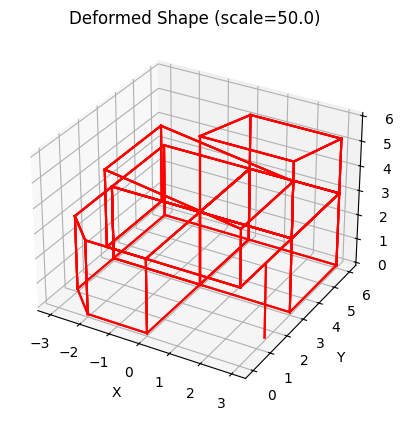

In [ ]:
def plot_deformed_3d(scale=1.0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Original vs. deformed coords
    deformed_coords = {}
    for (x,y,z), nd_id in node_map.items():
        disp = ops.nodeDisp(nd_id)
        dx, dy, dz = disp[0], disp[1], disp[2]  # 3D translations
        deformed_coords[nd_id] = (x + scale*dx, y + scale*dy, z + scale*dz)

    # Plot elements
    elemTag = 1
    for idx, row in combined_df.iterrows():
        ndI = int(row["startNode"])
        ndJ = int(row["endNode"])
        if ndI in deformed_coords and ndJ in deformed_coords:
            xI, yI, zI = deformed_coords[ndI]
            xJ, yJ, zJ = deformed_coords[ndJ]
            ax.plot([xI, xJ], [yI, yJ], [zI, zJ], color="red")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"Deformed Shape (scale={scale})")
    plt.show()

# Plot with an arbitrary scale factor
plot_deformed_3d(scale=50.0)


In [ ]:
import numpy as np
import pandas as pd
import openseespy.opensees as ops

# For plotting and animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# --------------------------------------------------------------
# 0. Assume you have already:
#    - Created nodes (ops.node(...))
#    - Defined elements (ops.element(...))
#    - Assigned loads or masses
#    - Performed static analysis ops.analyze(...)
# --------------------------------------------------------------


In [ ]:
# node_map:  (x, y, z) -> nodeID
# Invert it to get nodeID -> (x, y, z)
node_coords = {}
for coord, nID in node_map.items():
    node_coords[nID] = coord


In [ ]:
displacements = {}
for nID in node_coords.keys():
    # ops.nodeDisp(nID) -> array [uX, uY, uZ, rX, rY, rZ] in 3D
    disp = ops.nodeDisp(nID)
    displacements[nID] = disp  # store entire array if you like


In [ ]:
def init():
    # Usually you can return an empty iterable or
    # set up lines in their initial positions (scale=0).
    # We'll do the latter so it starts from undeformed.
    for (line, start_id, end_id) in lines:
        (x0, y0, z0) = node_coords[start_id]
        (x1, y1, z1) = node_coords[end_id]
        line.set_data_3d([x0, x1], [y0, y1], [z0, z1])
    return [l[0] for l in lines]

def animate(i):
    # i runs from 0..(nFrames-1). Let's vary scale from 0..maxScale
    nFrames = 30  # or however many frames you want
    scale = (i / (nFrames - 1)) * maxScale

    # Update each line
    for (line, start_id, end_id) in lines:
        (x0, y0, z0) = node_coords[start_id]
        (x1, y1, z1) = node_coords[end_id]

        # Node displacements
        dx0, dy0, dz0 = displacements[start_id][0:3]
        dx1, dy1, dz1 = displacements[end_id][0:3]

        # Deformed coords
        x0_def = x0 + scale * dx0
        y0_def = y0 + scale * dy0
        z0_def = z0 + scale * dz0
        x1_def = x1 + scale * dx1
        y1_def = y1 + scale * dy1
        z1_def = z1 + scale * dz1

        # Update line data
        # In 3D, we do:
        line.set_data_3d([x0_def, x1_def],
                         [y0_def, y1_def],
                         [z0_def, z1_def])

    # Return updated artists
    return [l[0] for l in lines]


In [ ]:
# Optionally compute min/max for x,y,z from the original node_coords
xs = [c[0] for c in node_coords.values()]
ys = [c[1] for c in node_coords.values()]
zs = [c[2] for c in node_coords.values()]

x_min, x_max = min(xs), max(xs)
y_min, y_max = min(ys), max(ys)
z_min, z_max = min(zs), max(zs)

# Expand a bit:
ax.set_xlim([x_min - 1, x_max + 1])
ax.set_ylim([y_min - 1, y_max + 1])
ax.set_zlim([z_min - 1, z_max + 1])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Animated Deformed Shape")


Text(0.5, 0.92, 'Animated Deformed Shape')

In [ ]:
from matplotlib.animation import FuncAnimation

nFrames = 30  # or however many steps you want
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=nFrames,
    interval=400,  # milliseconds between frames
    blit=True  # advanced: can speed up rendering
)

plt.show()


In [ ]:
anim.save("deformed_animation.gif", writer="imagemagick", fps=5)
# or
# anim.save("deformed_animation.mp4", writer="ffmpeg", fps=5)


In [ ]:
from openseespy.opensees import *

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Start of model generation
# -----------------------------

# remove existing model
wipe()

# set modelbuilder
model('basic', '-ndm', 2, '-ndf', 2)

# create nodes
node(1, 0.0, 0.0)
node(2, 144.0,  0.0)
node(3, 168.0,  0.0)
node(4,  72.0, 96.0)

# set boundary condition
fix(1, 1, 1)
fix(2, 1, 1)
fix(3, 1, 1)

# define materials
uniaxialMaterial("Elastic", 1, 3000.0)

# define elements
element("Truss",1,1,4,10.0,1)
element("Truss",2,2,4,5.0,1)
element("Truss",3,3,4,5.0,1)

# create TimeSeries
timeSeries("Linear", 1)

# create a plain load pattern
pattern("Plain", 1, 1)

# Create the nodal load - command: load nodeID xForce yForce
load(4, 100.0, -50.0)

# ------------------------------
# Start of analysis generation
# ------------------------------

# create SOE
system("BandSPD")

# create DOF number
numberer("RCM")

# create constraint handler
constraints("Plain")

# create integrator
integrator("LoadControl", 1.0)

# create algorithm
algorithm("Linear")

# create analysis object
analysis("Static")

# perform the analysis
analyze(1)

ux = nodeDisp(4,1)
uy = nodeDisp(4,2)
if abs(ux-0.53009277713228375450)<1e-12 and abs(uy+0.17789363846931768864)<1e-12:
    print("Passed!")
else:
    print("Failed!")

Passed!
